In [1]:
from qiskit import *
from qiskit_aer import Aer, AerSimulator
import math

In [2]:
# Add edges to the adjacency list
def add_edge(adj_list, u, v):
    adj_list[u].append(v)
    adj_list[v].append(u)

# Example usage:
num_vertices = 3

# Create an empty adjacency list
adj_list = [[] for _ in range(num_vertices)]

add_edge(adj_list, 0, 1)
add_edge(adj_list, 1, 2)

# max degree of any V
max_degree = 0
# Print the adjacency list
for i, neighbors in enumerate(adj_list):
    max_degree = max(max_degree, len(neighbors))
    print(f"Vertex {i}: {neighbors}")

Vertex 0: [1]
Vertex 1: [0, 2]
Vertex 2: [1]


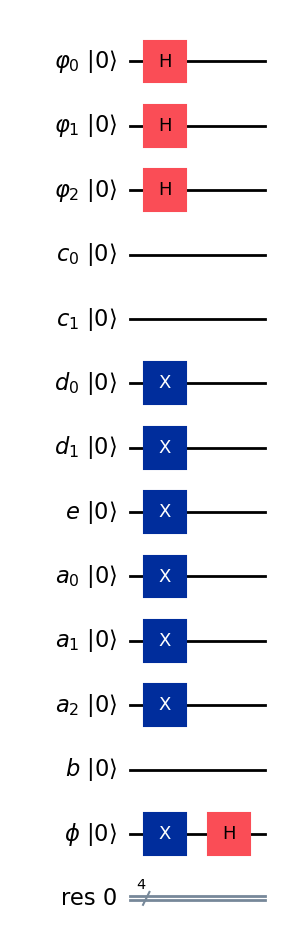

In [3]:
# quantum circuit (2n + 2m + 3)
from qiskit.circuit.library import MCXGate

m = max_degree
n = num_vertices

si = QuantumRegister(n, 'φ')
c = QuantumRegister(m, 'c')
d = QuantumRegister(m, 'd')
e = QuantumRegister(1, 'e')
a = QuantumRegister(n, 'a')
b = QuantumRegister(1, 'b')
si_f = QuantumRegister(1, 'ϕ')
res = ClassicalRegister(n+1, 'res')

circuit = QuantumCircuit(si, c, d, e, a, b, si_f, res)

# initialization 
# ϕi = |0>, c = |0>, d = |1>, e = |1>, a = |1>, b = |0>, ϕf = |1>
circuit.h(si[0:n])

circuit.x(d[0:m])
circuit.x(e[0:m])
circuit.x(a[0:n])

circuit.x(si_f[0])
circuit.h(si_f[0])

%matplotlib inline 
circuit.draw('mpl', initial_state=True, fold=-1)

In [4]:
def grovers():
    # si[i] and a[i]
    for i in range(n):
        l  = []
        ctl_state = "0"
        l.append(si[i])
        for j in adj_list[i]:
            ctl_state += "0"
            l.append(si[j])
        l.append(a[i])
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), l)

    # a[i] and b
    circuit.mcx(a, b[0])
    # si[i] and a[i]
    for i in range(n-1,-1,-1):
        l  = []
        ctl_state = "0"
        l.append(si[i])
        for j in adj_list[i]:
            ctl_state += "0"
            l.append(si[j])
        l.append(a[i])
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), l)


    circuit.barrier(si, c, d, e, a, b, si_f)

    # loop over all vertices
    for i in range(n-1):
        l = len(adj_list[i])
        ctl_state = ''
        gate = []
        #loop over all neighbours of current vertex and build an ccx gate for each edge
        for j in range(l):
            circuit.mcx([si[i],si[adj_list[i][j]]], c[j])
            ctl_state += '0'
            gate.append(c[j])
        gate.append(e)
        store_gate = gate
        store_ctl_state = ctl_state
        #gate 
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)

        d_num = 0
        for j in range(l):
            ctl_state = '0'
            gate = []
            for k in adj_list[adj_list[i][j]]:
                if k!=i:
                    ctl_state += '0'
                    gate.append(si[k])
            gate.append(si[adj_list[i][j]])
            gate.append(d[d_num])
            circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
            d_num+=1

        gate = d[0:d_num]
        gate.append(e)
        circuit.mcx(gate, a[i])

        d_num-=1
        for j in range(l-1, -1, -1):
            ctl_state = '0'
            gate = []
            for k in adj_list[adj_list[i][j]]:
                if k!=i:
                    ctl_state += '0'
                    gate.append(si[k])
            gate.append(si[adj_list[i][j]])
            gate.append(d[d_num])
            circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
            d_num-=1

        circuit.append(MCXGate(len(store_ctl_state), ctrl_state=store_ctl_state), store_gate)

        for j in range(l-1, -1, -1):
            circuit.mcx([si[i],si[adj_list[i][j]]], c[j])

    i = n-1
    l = len(adj_list[i])
    ctl_state = ''
    gate = []
    for j in range(l):
        circuit.mcx([si[i],si[adj_list[i][j]]], c[j])
        ctl_state += '0'
        gate.append(c[j])
    gate.append(e)
    store_gate = gate
    store_ctl_state = ctl_state
    circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)

    d_num = 0
    for j in range(l):
        ctl_state = '0'
        gate = []
        for k in adj_list[adj_list[i][j]]:
            if k!=i:
                ctl_state += '0'
                gate.append(si[k])
        gate.append(si[adj_list[i][j]])
        gate.append(d[d_num])
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
        d_num+=1

    gate = d[0:d_num]
    gate.append(e)
    circuit.mcx(gate, a[i])

    gate = a[0:n]
    gate.append(b)
    circuit.mcx(gate, si_f)


    gate = d[0:d_num]
    gate.append(e)
    circuit.mcx(gate, a[i])

    d_num-=1
    for j in range(l-1, -1, -1):
        ctl_state = '0'
        gate = []
        for k in adj_list[adj_list[i][j]]:
            if k!=i:
                ctl_state += '0'
                gate.append(si[k])
        gate.append(si[adj_list[i][j]])
        gate.append(d[d_num])
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
        d_num-=1

    circuit.append(MCXGate(len(store_ctl_state), ctrl_state=store_ctl_state), store_gate)

    for j in range(l-1, -1, -1):
        circuit.mcx([si[i],si[adj_list[i][j]]], c[j])


    for i in range(n-2, -1, -1):
        l = len(adj_list[i])
        ctl_state = ''
        gate = []
        for j in range(l):
            circuit.mcx([si[i],si[adj_list[i][j]]], c[j])
            ctl_state += '0'
            gate.append(c[j])
        gate.append(e)
        store_gate = gate
        store_ctl_state = ctl_state
        circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)

        d_num = 0
        for j in range(l):
            ctl_state = '0'
            gate = []
            for k in adj_list[adj_list[i][j]]:
                if k!=i:
                    ctl_state += '0'
                    gate.append(si[k])
            gate.append(si[adj_list[i][j]])
            gate.append(d[d_num])
            circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
            d_num+=1

        store_d_num = d_num
        gate = d[0:d_num]
        gate.append(e)
        circuit.mcx(gate, a[i])

        d_num-=1
        for j in range(l-1, -1, -1):
            ctl_state = '0'
            gate = []
            for k in adj_list[adj_list[i][j]]:
                if k!=i:
                    ctl_state += '0'
                    gate.append(si[k])
            gate.append(si[adj_list[i][j]])
            gate.append(d[d_num])
            circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
            d_num-=1

        circuit.append(MCXGate(len(store_ctl_state), ctrl_state=store_ctl_state), store_gate)

        for j in range(l-1, -1, -1):
            circuit.mcx([si[i],si[adj_list[i][j]]], c[j])

    circuit.barrier(si, c, d, e, a, b, si_f)
    circuit.h(si[0:n])
    ctl_state = '0'*n
    gate = si[0:n]
    gate.append(si_f)
    circuit.append(MCXGate(len(ctl_state), ctrl_state=ctl_state), gate)
    circuit.h(si[0:n])

    circuit.barrier(si, c, d, e, a, b, si_f)

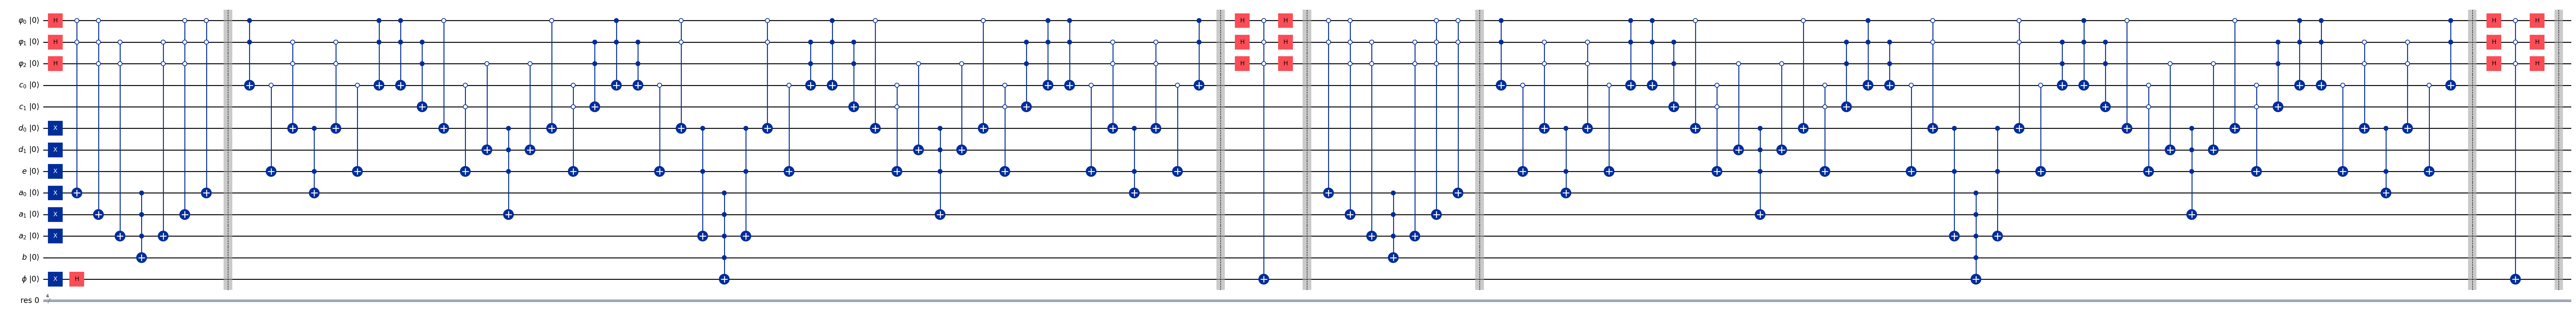

In [5]:
itr_num = math.ceil(math.sqrt(n))
for i in range(itr_num):
    grovers()
%matplotlib inline 
circuit.draw('mpl', initial_state=True, fold=-1)

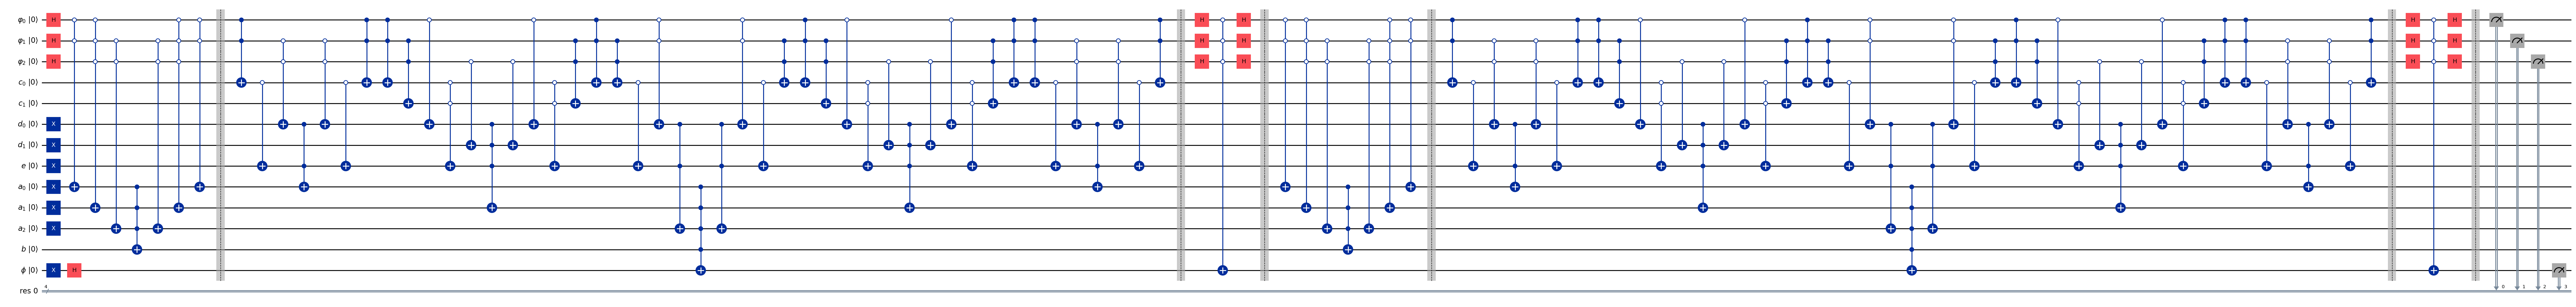

In [6]:
for i in range(n):
    circuit.measure(si[i], res[i])
circuit.measure(si_f[0], res[n])
%matplotlib inline 
circuit.draw('mpl', initial_state=True, fold=-1)

In [7]:
qc = transpile(circuit, AerSimulator())
result = Aer.get_backend('qasm_simulator').run(qc).result()

In [8]:
counts = {}
for key in result.get_counts():
    if key[0] == '1':
        counts[key] = result.get_counts().get(key)
print(counts)

{'1010': 171, '1001': 5, '1110': 64, '1011': 58, '1000': 4, '1101': 166, '1100': 3, '1111': 62}


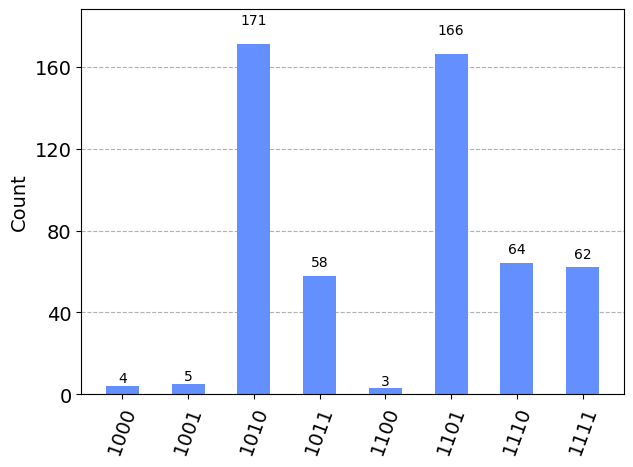

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)